# 13. 프로젝트 - Movielens 영화 추천 실습

---
## Step 0.

In [1]:
# !pip install implicit

In [2]:
import pandas as pd
import numpy as np
import os
import scipy
import implicit

In [3]:
# Google Drive - Colab  연동을 위한 라이브러리 Import
# from google.colab import drive
# drive.mount('/content/drive')
# data_dir = '/content/drive/MyDrive/Exploration/data'

---
## Step 1. 데이터 준비와 전처리
Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔하게 정리되어 있습니다.

In [4]:
rating_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [6]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [7]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


---
## Step 2. 분석
- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [8]:
# ratings에 있는 유니크한 영화 개수
ratings['movie_id'].nunique()

3628

In [9]:
# ratings에 있는 유니크한 사용자 수
ratings['user_id'].nunique()

6039

In [10]:
movies_data = pd.merge(left = ratings , right = movies, how = "inner", on = "movie_id")
movies_data.head(10)

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
5,18,1193,4,978156168,One Flew Over the Cuckoo's Nest (1975),Drama
6,19,1193,5,982730936,One Flew Over the Cuckoo's Nest (1975),Drama
7,24,1193,5,978136709,One Flew Over the Cuckoo's Nest (1975),Drama
8,28,1193,3,978125194,One Flew Over the Cuckoo's Nest (1975),Drama
9,33,1193,5,978557765,One Flew Over the Cuckoo's Nest (1975),Drama


In [11]:
# 결측치 확인
movies_data.isnull().sum()

user_id      0
movie_id     0
counts       0
timestamp    0
title        0
genre        0
dtype: int64

In [12]:
# 평점 3,4,5 모두 인기있는 경우라고 정한다.
# 3,4,5점을 한번 받으면 1 count로 정하고, 각 영화에 대한 총 count수를 로 정렬한다. 
movies_count = movies_data.groupby('title')['counts'].count()

movies_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

---
## Step 3. 선호하는 영화를 5가지 골라서 ratings에 추가

In [13]:
# [title] input -> [movie_id] output
def title_in_id_out(title):
    a=movies_data[movies_data['title'].isin([title])] # title칼럼중 인자로 들어온 title과 같은 행렬 추출
    mv_id=a.iloc[0,1] #추출된 행렬중 0번째 행의 1번째칼럼[movie_id] 값 가져온다.
    return mv_id
#title가 'Matrix, The (1999)'인 movie_id 출력
title_in_id_out('Matrix, The (1999)')

2571

In [14]:
# [movie_id] output -> [title] input
def id_in_title_out(movie_id):
    a=movies_data[movies_data['movie_id'].isin([movie_id])] # movie_id칼럼중 인자에 들어온 영화id와 같은 행렬 추출
    title=a.iloc[0,4] #추출된 행렬중 0번째 행의 4번째칼럼[title] 값 가져온다.
    return title

#moive_id가 2571인 title값 출력
id_in_title_out(2571)

'Matrix, The (1999)'

In [15]:
# 영화 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
#선호 영화 리스트 생성
my_favorite = ['Matrix, The (1999)', 'Back to the Future (1985)', 'Men in Black (1997)', 'Terminator, The (1984)' ,'Jurassic Park (1993)']
my_movie_id = []


#선호 영화 딕셔너리 생성
dir_favorite ={} #{'title' :'movie_id'} 딕셔너리
 
for title in my_favorite:
    mv_id = title_in_id_out(title)
    my_movie_id.append(mv_id) 
    print('Title : ',title,'\t\t Movie ID : ', mv_id)
    
    dir_favorite[title]=int(mv_id)
    print('Title : ',title,'\t\t Movie ID : ', dir_favorite[title])
    
       

#print(movies_data.columns)
#movies_data.sort_values(by='movie_id')
my_movie_id

Title :  Matrix, The (1999) 		 Movie ID :  2571
Title :  Matrix, The (1999) 		 Movie ID :  2571
Title :  Back to the Future (1985) 		 Movie ID :  1270
Title :  Back to the Future (1985) 		 Movie ID :  1270
Title :  Men in Black (1997) 		 Movie ID :  1580
Title :  Men in Black (1997) 		 Movie ID :  1580
Title :  Terminator, The (1984) 		 Movie ID :  1240
Title :  Terminator, The (1984) 		 Movie ID :  1240
Title :  Jurassic Park (1993) 		 Movie ID :  480
Title :  Jurassic Park (1993) 		 Movie ID :  480


[2571, 1270, 1580, 1240, 480]

In [16]:
# user_id 마지막은 6040
# user_id은 1부터 시작해서 6040개로 끝난다면 유니크한 값은 6040개가 되어야되는데 6039개다 ,그럼 중간에 한개의 값이 없다고 추측된다.
print(ratings['user_id'].nunique()) 
movies_data.sort_values(by='user_id',ascending=True, inplace=False)

6039


,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
31113,1,2294,4,978824291,Antz (1998),Animation|Children's
31674,1,3186,4,978300019,"Girl, Interrupted (1999)",Drama
32044,1,1566,4,978824330,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical
32415,1,588,4,978824268,Aladdin (1992),Animation|Children's|Comedy|Musical
...,...,...,...,...,...,...
657728,6040,334,4,957717503,Vanya on 42nd Street (1994),Drama
393446,6040,1294,4,957716949,M*A*S*H (1970),Comedy|War
253075,6040,994,3,960972693,Big Night (1996),Drama
127665,6040,2396,3,956704475,Shakespeare in Love (1998),Comedy|Romance


In [17]:
#my_moivelist = pd.DataFrame({'user_id': [0]*5, 'movie_id': my_movie_id, 'count':[5]*5})
my_moivelist = pd.DataFrame({'user_id': ['unknown']*5, 'movie_id': my_movie_id, 'counts':[5]*5})

# 사용자는 6039이였기때문에  나에대한 유저번호는 6040으로 설정한다.
if not ratings.isin({'user_id':[6041]})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    ratings = ratings.append(my_moivelist)              

ratings.tail(10)

,user_id,movie_id,counts,timestamp
1000203,6040,1090,3,956715518.0
1000205,6040,1094,5,956704887.0
1000206,6040,562,5,956704746.0
1000207,6040,1096,4,956715648.0
1000208,6040,1097,4,956715569.0
0,unknown,2571,5,NaN
1,unknown,1270,5,NaN
2,unknown,1580,5,NaN
3,unknown,1240,5,NaN
4,unknown,480,5,NaN


In [18]:
print('기본행 개수',len(movies_data))
movies_data = pd.merge(left = ratings , right = movies, how = "inner", on = "movie_id")
movies_data.head(10)
print('추가후 행 개수',len(movies_data))
movies_data.tail(5)

기본행 개수 836478
추가후 행 개수 836483


,user_id,movie_id,counts,timestamp,title,genre
836478,5851,3607,5,9.577566e+08,One Little Indian (1973),Comedy|Drama|Western
836479,5854,3026,4,9.583469e+08,Slaughterhouse (1987),Horror
836480,5854,690,3,9.577443e+08,"Promise, The (Versprechen, Das) (1994)",Romance
836481,5938,2909,4,9.572734e+08,"Five Wives, Three Secretaries and Me (1998)",Documentary
836482,5948,1360,5,1.016564e+09,Identification of a Woman (Identificazione di ...,Drama


In [19]:
movies_tmp= movies_data.loc[:,['user_id','movie_id','counts']]
movies_tmp

,user_id,movie_id,counts
0,1,1193,5
1,2,1193,5
2,12,1193,4
3,15,1193,4
4,17,1193,5
...,...,...,...
836478,5851,3607,5
836479,5854,3026,4
836480,5854,690,3
836481,5938,2909,4


In [20]:
# 고유한 유저, movie_id를 찾아내는 코드
user_unique = movies_tmp['user_id'].unique()
movie_unique = movies_tmp['movie_id'].unique()

# 유저id, 영화id indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [21]:
num=0
for key, value in user_to_idx.items():
    print('user_id:{}    ,user_idx:{}'.format(key, value))
    num+=1
    if num>5:
        break
print('user_to_idx의 사이즈:', len(user_to_idx))

user_id:1    ,user_idx:0
user_id:2    ,user_idx:1
user_id:12    ,user_idx:2
user_id:15    ,user_idx:3
user_id:17    ,user_idx:4
user_id:18    ,user_idx:5
user_to_idx의 사이즈: 6040


In [22]:
num=0
for key, value in movie_to_idx.items():
    print('movie_id:{}    ,movie_idx:{}'.format(key, value))
    num+=1
    if num>5:
        break
print('movie_to_idx의 사이즈:', len(movie_to_idx))

movie_id:1193    ,movie_idx:0
movie_id:661    ,movie_idx:1
movie_id:914    ,movie_idx:2
movie_id:3408    ,movie_idx:3
movie_id:2355    ,movie_idx:4
movie_id:1197    ,movie_idx:5
movie_to_idx의 사이즈: 3628


In [23]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = movies_tmp['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(movies_tmp):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    movies_tmp['user_id'] = temp_user_data   # movies_tmp['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

#movie_id를 통해 movie 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = movies_tmp['movie_id'].map(movie_to_idx.get).dropna()
if len(temp_movie_data) == len(movies_tmp):
    print('movie column indexing OK!!')
    movies_tmp['movie_id'] = temp_movie_data
else:
    print('movie column indexing Fail!!')

movies_tmp

user_id column indexing OK!!
movie column indexing OK!!


,user_id,movie_id,counts
0,0,0,5
1,1,0,5
2,2,0,4
3,3,0,4
4,4,0,5
...,...,...,...
836478,1621,3623,5
836479,3481,3624,4
836480,3481,3625,3
836481,4159,3626,4


---
## Step 4. CSR(Compressed Sparse Row) Matrix

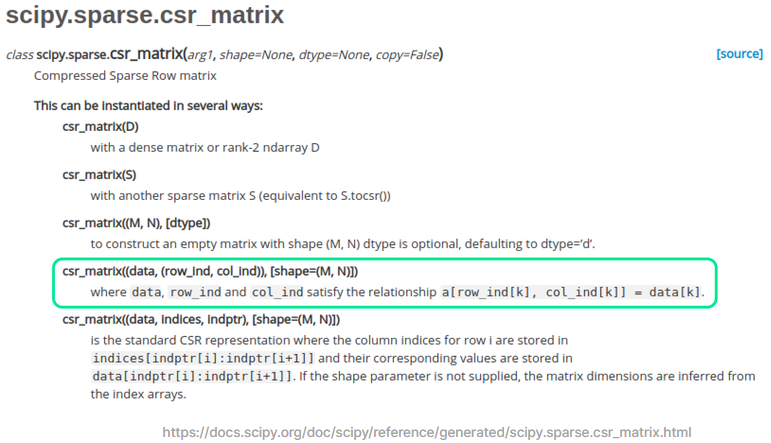

In [24]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = movies_tmp['user_id'].nunique()
num_movie = movies_tmp['movie_id'].nunique()


#=> csr_matrix((data, indices, indptr), shape=(row, col))
csr_data = csr_matrix((movies_tmp['counts'], (movies_tmp['user_id'], movies_tmp['movie_id'])), shape= (num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

---
## Step 5. als_model = AlternatingLeastSquares 모델 구성/훈련
- implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지입니다.
- 이 패키지에 구현된 als(AlternatingLeastSquares) 모델을 사용하겠습니다. Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있습니다.

In [25]:
from implicit.als import AlternatingLeastSquares

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
3. use_gpu : GPU를 사용할 것인지
4. iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

1과 4를 늘릴수록 학습 데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 합니다.

In [26]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [27]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [28]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

---
## Step 6. 훈련된 모델이 예측한 나의 선호도

In [29]:
# unknown idx값 찾기
unknown_idx_num = user_to_idx['unknown']
print(unknown_idx_num)

5170


In [30]:
unknown_idx = user_to_idx['unknown']
new_movie_idx = movie_to_idx[dir_favorite['Matrix, The (1999)']]
unknown_vector = als_model.user_factors[unknown_idx],
new_movie_vector = als_model.item_factors[new_movie_idx]

print('unknown의 인덱스:{}  , new_movie_idx 인덱스:{}'.format(unknown_idx, new_movie_idx) )

unknown의 인덱스:5170  , new_movie_idx 인덱스:124


In [31]:
new_movie_vector

array([ 0.02171895,  0.01928538, -0.03434064, -0.0044032 ,  0.0082101 ,
       -0.00496944,  0.03230873,  0.01171996,  0.01229796, -0.00085315,
        0.00795657, -0.01267156,  0.00366233,  0.02508464,  0.0037411 ,
        0.00489033, -0.00148289,  0.0135823 , -0.00827256,  0.00229129,
        0.03019948,  0.02204383, -0.01144196,  0.01365748,  0.0103219 ,
        0.00587176, -0.00116651,  0.01179854,  0.02438791,  0.00417802,
        0.01143715, -0.00164611,  0.02124644,  0.05703427, -0.00235641,
        0.03286057,  0.01560492,  0.00844278,  0.01160872, -0.01404122,
       -0.02258033, -0.01687871,  0.02233244, -0.00913006,  0.00292217,
        0.00364084, -0.01491996,  0.00140935,  0.00502986,  0.03408102,
        0.00941291,  0.02565929,  0.01612861, -0.00761853, -0.00114099,
        0.01719323,  0.0053717 ,  0.0190453 , -0.00263229,  0.01399783,
       -0.01599085,  0.04031647,  0.03138619,  0.01785379,  0.01020897,
        0.00285895, -0.0205858 , -0.02988921,  0.00076859,  0.01

In [32]:
np.dot(unknown_vector, new_movie_vector) # vector를 내적했을 때의 값 확인

array([0.64657986], dtype=float32)

엄밀히 말하면 1이 나와야 하지만 0.68이 나왔다. factors를 늘리거나 iterations를 늘리면 해결에 가까워 질 수 있다고 한다.  
하지만 추천시스템에서 값으로써 정확도를 판단하기는 어렵다. 객관성이나 경험등의 다양한 요소를 통해 결정되기 때문이다.  
사람의 마음을 정확히 안다는 것 자체가 불가능한 일이기 때문에, 객관적인 지표를 정하기 어려운 것이다.

---
## Step 7. 좋아하는 영화와 비슷한 영화 추천
AlternatingLeastSquares 클래스에 구현되어 있는 similar_items 메서드를 통하여 비슷한 영화를 찾습니다.

In [33]:
#AlternatingLeastSquares 클래스 
#similar_items 메서드를 통하여 비슷한 영화를 찾습니다
print(my_favorite[1])

Back to the Future (1985)


In [34]:
favorite_movie = 'Back to the Future (1985)'
movie_id = movie_to_idx[title_in_id_out(favorite_movie)]
similar_movie = als_model.similar_items(movie_id, N=10)
similar_movie
#(영화의 idx, 유사도) Tuple 로 반환

[(22, 0.9999999),
 (13, 0.61460274),
 (488, 0.546514),
 (243, 0.5426641),
 (674, 0.5160723),
 (19, 0.5068385),
 (26, 0.49938917),
 (615, 0.45283636),
 (1144, 0.4307139),
 (169, 0.4285124)]

Back to the Future (1985)가 기준점이라서 유사도가 1임을 확인 할 수 있다.

(영화의 idx, 유사도) 형태의 Tuple 로 반환하고 있습니다.  
idx를 다시 영화 제목으로 매핑 시켜 주겠습니다.

In [35]:
#movie_to_idx 를 뒤집어, index로부터 movie_id를  얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}

for i in similar_movie:
    idx = i[0]
    moive_id = idx_to_movie[idx]
    print('idx:{},   moive_id:{} '.format(idx,moive_id))
    print(id_in_title_out(moive_id),'\n')

idx:22,   moive_id:1270 
Back to the Future (1985) 

idx:13,   moive_id:2918 
Ferris Bueller's Day Off (1986) 

idx:488,   moive_id:1307 
When Harry Met Sally... (1989) 

idx:243,   moive_id:2716 
Ghostbusters (1984) 

idx:674,   moive_id:2011 
Back to the Future Part II (1989) 

idx:19,   moive_id:2797 
Big (1988) 

idx:26,   moive_id:1097 
E.T. the Extra-Terrestrial (1982) 

idx:615,   moive_id:2407 
Cocoon (1985) 

idx:1144,   moive_id:3361 
Bull Durham (1988) 

idx:169,   moive_id:1079 
Fish Called Wanda, A (1988) 



전부 오래된 영화라서 잘은 모르지만

- Ferris Bueller's Day Off (1986) : 코미디
- Ghostbusters (1984) : SF/호러/코미디/액션
- Back to the Future Part II (1989) : 모험/코미디/SF
- When Harry Met Sally... (1989) : 코미디/드라마/로맨스
- Fish Called Wanda, A (1988) : 코미디/범죄
- Cocoon (1985) : SF
- Big (1988) : 드라마/판타지
- Bull Durham (1988) : 드라마/코미디
- Star Wars: Episode IV - A New Hope (1977) : 액션/모험/판타지

얼추 비슷하게 추천된 것 같다!

---
## Step 8. 가장 좋아할 만한 영화들을 추천

In [36]:
user = user_to_idx['unknown']
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=10, filter_already_liked_items=True)
movie_recommended

[(92, 0.73857534),
 (62, 0.50585246),
 (44, 0.37248826),
 (117, 0.34570283),
 (87, 0.31999424),
 (375, 0.31415522),
 (317, 0.30862394),
 (141, 0.29845098),
 (64, 0.29456872),
 (145, 0.29315814)]

In [37]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}

for i in movie_recommended:
    idx = i[0]
    moive_id = idx_to_movie[idx]
    print('idx:{},   moive_id:{} '.format(idx,moive_id))
    print(id_in_title_out(moive_id),'\n')

idx:92,   moive_id:589 
Terminator 2: Judgment Day (1991) 

idx:62,   moive_id:2916 
Total Recall (1990) 

idx:44,   moive_id:260 
Star Wars: Episode IV - A New Hope (1977) 

idx:117,   moive_id:1196 
Star Wars: Episode V - The Empire Strikes Back (1980) 

idx:87,   moive_id:110 
Braveheart (1995) 

idx:375,   moive_id:1573 
Face/Off (1997) 

idx:317,   moive_id:32 
Twelve Monkeys (1995) 

idx:141,   moive_id:457 
Fugitive, The (1993) 

idx:64,   moive_id:1210 
Star Wars: Episode VI - Return of the Jedi (1983) 

idx:145,   moive_id:1527 
Fifth Element, The (1997) 



마찬가지로 수치상으로는 분포가 다소 상이하지만, 어쨋거나 SF/판타지/호러인 영화들이 추천된 것을 확인 할 수 있다.

---
## Discussion

- Google colab에서 에러가 발생해서 한참 고생하다 해결 못 했는데, LMS에서 에러없이 수행되었다. python 버전 문제인가?
- 이전 프로젝트부터 보이는 양상이지만, AI만으로 완벽하게 해결 할 수 없는 문제(주관성과 같은 것)들을 접하고 있어서 신선했다.
- 외부 모델을 사용했기에 모델에 대한 자세한 이해가 따라오지는 않았지만, 추천시스템에 대한 전반적인 이해도를 키울 수 있는 노드였다.
- AlternatingLeastSquares 클래스의 __init__ 파라미터 외에는 특별한 파라미터가 없어서 어려운 점은 없었다.

fin.